## **EX1-Q3** ##

In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58822000 @  0x7f83c0f6f2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, sampler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [5]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
def evaluate_loss(model, data, labels, loss_fn):
    """
    evaluate the loss
    """
    predicted = model(data)
    errors = loss_fn(predicted, labels)
    return float(errors)

def plot_faces(axes, img_indxs, model, shape):
    for ax, img_indx in zip(axes.reshape(-1), img_indxs):
        pred = ((model(X_val[img_indx].view(shape)) + 1) * 48).detach().cpu().numpy().reshape(15, 2)
        y_t = ((Y_val[img_indx] + 1) * 48).cpu().numpy().reshape(15, 2)
        ax.imshow(X_val[img_indx].cpu().numpy().reshape(96, 96), cmap="gray")
        ax.scatter(pred[:, 0], pred[:, 1], color='r', s=20)
        ax.scatter(y_t[:, 0], y_t[:, 1], color='b', s=20)

def plot_loss(train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.show()
  
def save_plot(name, train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.savefig(name)

def train(model, epochs, loader, loss_fn, optimizer, scheduler, X_val, Y_val, print_every=10):
    train_loss = []
    val_loss = []
    train_loss.append(evaluate_loss(model, X_train, Y_train, loss_fn))
    val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
    for e in range(1,epochs + 1):
        batches_loss = []
        for t, (x, y) in enumerate(loader):
            scheduler.step()
            model.train()
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = model(x)
            # Calculate Loss
            loss = loss_fn(y_pred, y)
            # optimization
            optimizer.zero_grad()
            # backward propagation
            loss.backward()
            # Updating parameters
            optimizer.step()
            batches_loss.append(loss.item())
        if e % print_every == 0:
            print(f'ephoc {e}, loss = {np.mean(np.array(batches_loss)):.4f}  val_loss = {evaluate_loss(model, X_val, Y_val, loss_fn):.4f}')
            
        train_loss.append(np.mean(np.array(batches_loss)))
        val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
        
    return train_loss, val_loss

class View(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [0]:
C = 1
L = 96
W = 96
flatten_dim = L * W
output_dim = 30
h = 100
val_precenteg = 0.15
BATCH_SIZE = 128
print_every = 10

In [8]:
from google.colab import files

uploaded = files.upload()

Saving training_filterd.csv to training_filterd.csv


### **Load data**

In [9]:
# loading data
data_frame = pd.read_csv('training_filterd.csv', sep=',').dropna()
Y = data_frame.values[:, 0:-1].astype(np.float)
Y = Y / 48 - 1
img_df = data_frame.iloc[:, -1]

X = []
for img_str in img_df.values:
    X.append(np.array(img_str.split(), dtype=np.float))
X = np.array(X)
X /= 255
N = X.shape[0]
X.shape, Y.shape

((2140, 9216), (2140, 30))

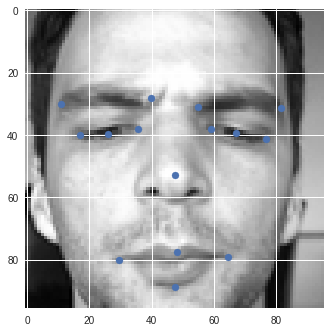

In [10]:
idx = 254
Y_t = ((Y[idx] + 1) * 48).reshape(15, 2)
plt.imshow(X[idx].reshape(96, 96), cmap="gray")
plt.scatter(Y_t[:, 0], Y_t[:, 1])
plt.show()

### **Fully connected neural network**

In [11]:
mask = np.arange(0, N)
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * val_precenteg)]
train_mask = mask[int(X.shape[0] * val_precenteg):]
X_val = torch.FloatTensor(X[val_mask]).to(device=device)
X_train = torch.FloatTensor(X[train_mask]).to(device=device)
Y_val = torch.FloatTensor(Y[val_mask]).to(device=device)
Y_train = torch.FloatTensor(Y[train_mask]).to(device=device)

print(X_train.shape)

torch.Size([1819, 9216])


In [69]:
X_val = X_val.view((X_val.shape[0], -1)).to(device=device)
X_train = X_train.view((X_train.shape[0], -1)).to(device=device)
X_train.shape, X_val.shape

(torch.Size([1819, 9216]), torch.Size([321, 9216]))

In [0]:
train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [0]:
linear_model = torch.nn.Sequential(nn.Linear(flatten_dim, h), nn.ReLU(), nn.Linear(h, output_dim)).to(device=device)

In [0]:
fc_train_loss_lst, fc_val_loss_lst = [], []
loss_fn = F.mse_loss

optimizer = optim.Adam(linear_model.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.0)

In [73]:
loss = train(linear_model, 100, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)
fc_train_loss_lst += loss[0]
fc_val_loss_lst += loss[1]

ephoc 10, loss = 0.0089  val_loss = 0.0110
ephoc 20, loss = 0.0073  val_loss = 0.0087
ephoc 30, loss = 0.0065  val_loss = 0.0082
ephoc 40, loss = 0.0064  val_loss = 0.0076
ephoc 50, loss = 0.0056  val_loss = 0.0070
ephoc 60, loss = 0.0054  val_loss = 0.0067
ephoc 70, loss = 0.0051  val_loss = 0.0065
ephoc 80, loss = 0.0050  val_loss = 0.0061
ephoc 90, loss = 0.0043  val_loss = 0.0057
ephoc 100, loss = 0.0041  val_loss = 0.0054


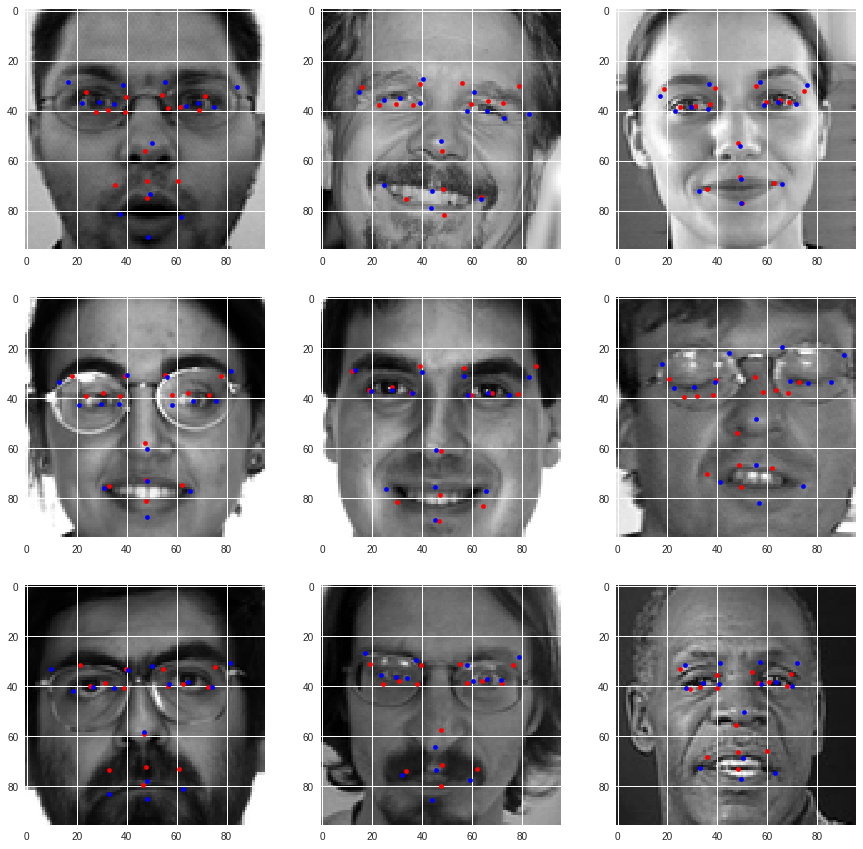

In [74]:
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5 * nrows, 5 * ncols))
imgs_indx = np.arange(Y_val.shape[0])
np.random.shuffle(imgs_indx)
plot_faces(ax, imgs_indx[:nrows * ncols], linear_model, (1, -1))
plt.show()

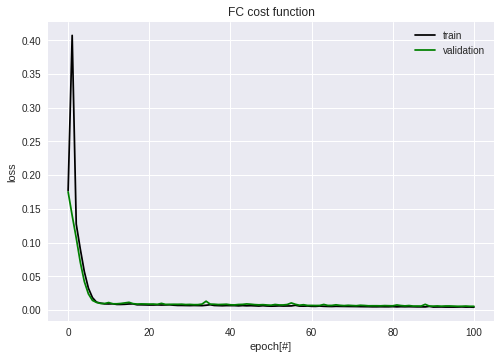

In [76]:
save_plot('linear_loss.png', fc_train_loss_lst, fc_val_loss_lst,
         title='FC cost function')
files.download('linear_loss.png')

### **Convolutional neural network**

In [64]:
X_val = X_val.view((-1, C, W, L)).to(device=device)
X_train = X_train.view((-1, C, W, L)).to(device=device)
X_train.shape, X_val.shape

(torch.Size([1819, 1, 96, 96]), torch.Size([321, 1, 96, 96]))

In [0]:
train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [0]:
conv_model = nn.Sequential(nn.Conv2d(1, 32, 3),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           nn.Conv2d(32,64, 2),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           nn.Conv2d(64, 128, 2),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           View(),
                           nn.Linear(15488, 500),
                           nn.ReLU(),
                           nn.Linear(500, 500),
                           nn.ReLU(),
                           nn.Linear(500, output_dim)).to(device=device)

In [0]:
conv_train_loss_lst, conv_val_loss_lst = [], []

loss_fn = F.mse_loss

optimizer = optim.Adam(conv_model.parameters(), lr=1e-3)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1.0)

In [58]:
loss = train(conv_model, 100, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)
conv_train_loss_lst += loss[0]
conv_val_loss_lst += loss[1]

ephoc 10, loss = 0.0025  val_loss = 0.0025
ephoc 20, loss = 0.0010  val_loss = 0.0015
ephoc 30, loss = 0.0006  val_loss = 0.0014
ephoc 40, loss = 0.0004  val_loss = 0.0012
ephoc 50, loss = 0.0003  val_loss = 0.0012
ephoc 60, loss = 0.0003  val_loss = 0.0012
ephoc 70, loss = 0.0002  val_loss = 0.0013
ephoc 80, loss = 0.0002  val_loss = 0.0012
ephoc 90, loss = 0.0001  val_loss = 0.0013
ephoc 100, loss = 0.0002  val_loss = 0.0013


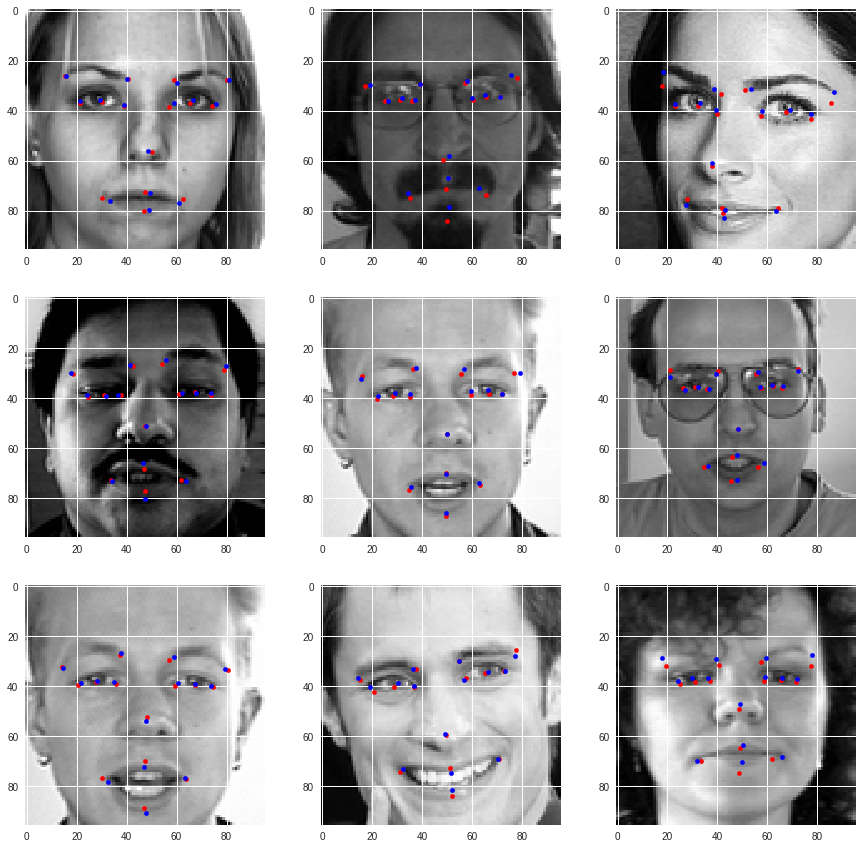

In [59]:
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5 * nrows, 5 * ncols))
imgs_indx = np.arange(Y_val.shape[0])
np.random.shuffle(imgs_indx)
plot_faces(ax, imgs_indx[:nrows * ncols],conv_model, (1, 1, 96, 96))
plt.show()

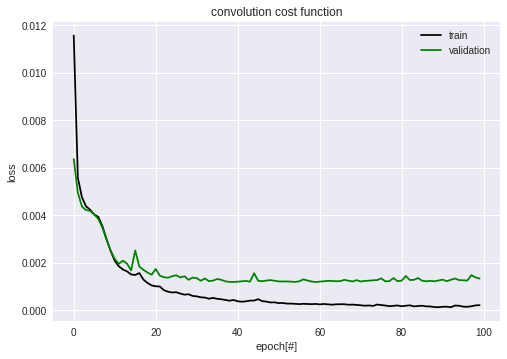

In [63]:
save_plot('convolotional_los.png', conv_train_loss_lst[1:], conv_val_loss_lst[1:], "convolution cost function")
files.download('convolotional_los.png')

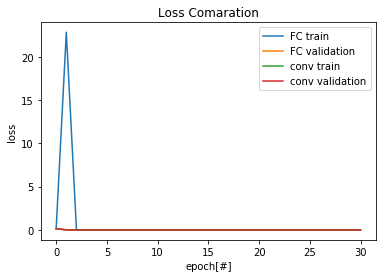

In [0]:
plt.plot(np.arange(len(fc_train_loss_lst)), fc_train_loss_lst, label='FC train')
plt.plot(np.arange(len(fc_val_loss_lst)), fc_val_loss_lst, label='FC validation')
plt.plot(np.arange(len(conv_train_loss_lst)), conv_train_loss_lst, label='conv train')
plt.plot(np.arange(len(conv_val_loss_lst)), conv_val_loss_lst, label='conv validation')

plt.legend()
plt.title("Loss Comaration")
plt.xlabel('epoch[#]')
plt.ylabel('loss')
plt.show()